# 使用频谱图和CNN进行音频分类

### 加载数据集

导入必要的python库

In [234]:
import torchaudio
import torchaudio.transforms as T
import random
import torch
import os
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

定义数据集类
数据预处理和数据增强
使用随机时间延迟、类相关时间拉伸和音高变换增强，特征使用对数缩放梅尔频谱图和其增强合成作为二通道输入网络

In [235]:
class AugmentedSpeechCommandsDataset(Dataset):
    def __init__(self, data, audio_dir, transform=None, sample_rate=22050, n_fft=1024, hop_length=512, segment_length=41, overlap=0.5):
        self.transform = transform
        self.data = data
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.segment_length = segment_length
        self.overlap = overlap
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=64
        )
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.data_X, self.data_y = self.__extract_features()

    def __len__(self):
        return len(self.data_X)

    def __getitem__(self, idx):
        return self.data_X[idx], self.data_y[idx]
    
    def __extract_features(self):
        data_X = []
        data_y = []

        for _, row in self.data.iterrows():
            audio_filename = row['filename']
            label = row['target']
        
            # 读取音频文件
            waveform, sr = torchaudio.load(audio_filename)
        
            # 重采样音频
            waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=self.sample_rate)

            # 特征提取：计算梅尔频谱图
            mel_spec = self.mel_spectrogram(waveform)
            log_mel_spec = self.amplitude_to_db(mel_spec)

            # 计算一阶增量（差分）
            delta = torchaudio.functional.compute_deltas(log_mel_spec)

            # 合并原始特征与增量特征
            features = torch.cat((log_mel_spec, delta), dim=0)
            
            #归一化
            mean = features.mean()
            std = features.std()
            features = (features - mean) / std

        
            # 切分为重叠段
            segments = []
            segment_labels = []
            step_size = int(self.segment_length * (1 - self.overlap))
        
            for start_idx in range(0, features.size(2) - self.segment_length + 1, step_size):
                end_idx = start_idx + self.segment_length
                segment = features[:, :, start_idx:end_idx]
                segments.append(segment)
                segment_labels.append(label)
        
            data_X.append(features)
            data_y.append(label)

        # 将列表转换为张量
        return torch.stack(data_X), torch.tensor(data_y)



加载数据集

In [236]:
data_csv_path = "/home/nlp/songcw/data/ESC-50-master/meta/esc50.csv"
audio_dir = "/home/nlp/songcw/data/ESC-50-master/audio/"

# 读取数据集信息
data = pd.read_csv(data_csv_path)
audio_filenames = data['filename'].tolist()
labels = data['target'].tolist()

print(np.unique(labels))

audio_files = ["/home/nlp/songcw/data/ESC-50-master/audio/" + filename for filename in audio_filenames]

# 划分训练集和验证集
train_filenames, val_filenames, train_labels, val_labels = train_test_split(audio_files, labels,
                                                                              test_size=0.2, random_state=42)

train_data = pd.DataFrame({'filename': train_filenames, 'target': train_labels})
val_data = pd.DataFrame({'filename': val_filenames, 'target': val_labels})

print('train_data',train_data)
print('val_data',val_data)

train_dataset = AugmentedSpeechCommandsDataset(train_data, audio_dir)
val_dataset = AugmentedSpeechCommandsDataset(val_data, audio_dir)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
train_data                                                filename  target
0     /home/nlp/songcw/data/ESC-50-master/audio/3-14...      29
1     /home/nlp/songcw/data/ESC-50-master/audio/1-50...      44
2     /home/nlp/songcw/data/ESC-50-master/audio/3-10...      25
3     /home/nlp/songcw/data/ESC-50-master/audio/2-69...       5
4     /home/nlp/songcw/data/ESC-50-master/audio/2-10...       3
...                                                 ...     ...
1595  /home/nlp/songcw/data/ESC-50-master/audio/3-18...      35
1596  /home/nlp/songcw/data/ESC-50-master/audio/4-15...      14
1597  /home/nlp/songcw/data/ESC-50-master/audio/3-11...      26
1598  /home/nlp/songcw/data/ESC-50-master/audio/4-18...      29
1599  /home/nlp/songcw/data/ESC-50-master/audio/3-18...       6

[1600 rows x 2 columns]
val_data                                  

查看数据集示例

In [237]:
# 查看数据集大小
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)

print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")

# 获取训练和验证数据加载器的批次数量
train_batches = len(train_loader)
val_batches = len(val_loader)

print(f"Number of batches in train loader: {train_batches}")
print(f"Number of batches in validation loader: {val_batches}")


# 查看train_loader中的几个样本
print("查看train_loader中的样本:")
for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):
    print(f"批次 {batch_idx}，样本数量: {batch_data.size(0)}")
    print("梅尔频谱图形状:", batch_data.shape)
    print("标签形状:", batch_labels.shape)
    print("部分标签示例:", batch_labels[:5])  # 查看前5个标签示例
    if batch_idx == 0:  # 只查看第一个批次
        break

# 查看val_loader中的几个样本
print("\n查看val_loader中的样本:")
for batch_idx, (batch_data, batch_labels) in enumerate(val_loader):
    print(f"批次 {batch_idx}，样本数量: {batch_data.size(0)}")
    print("梅尔频谱图形状:", batch_data.shape)
    print("标签形状:", batch_labels.shape)
    print("部分标签示例:", batch_labels[:5])  # 查看前5个标签示例
    if batch_idx == 0:  # 只查看第一个批次
        break


Train dataset size: 1600
Validation dataset size: 400
Number of batches in train loader: 50
Number of batches in validation loader: 13
查看train_loader中的样本:
批次 0，样本数量: 32
梅尔频谱图形状: torch.Size([32, 2, 64, 216])
标签形状: torch.Size([32])
部分标签示例: tensor([18, 16, 46,  7,  0])

查看val_loader中的样本:
批次 0，样本数量: 32
梅尔频谱图形状: torch.Size([32, 2, 64, 216])
标签形状: torch.Size([32])
部分标签示例: tensor([22, 17, 45, 22, 21])


梅尔频谱图展示

查看train_loader中的样本:
批次 0，样本数量: 32
梅尔频谱图形状: torch.Size([32, 2, 64, 216])


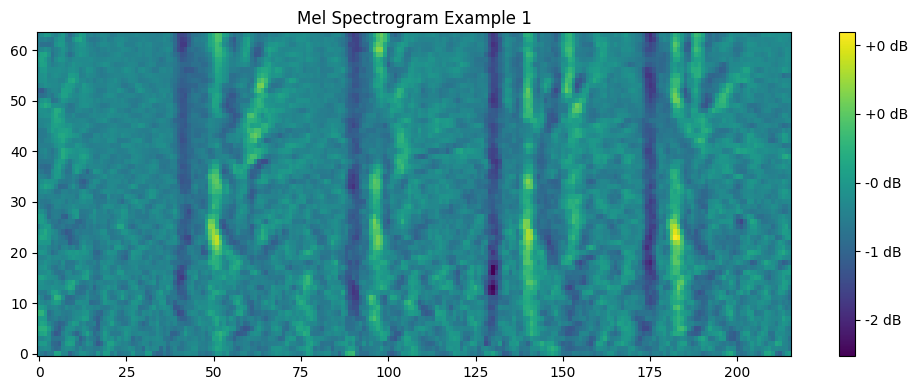

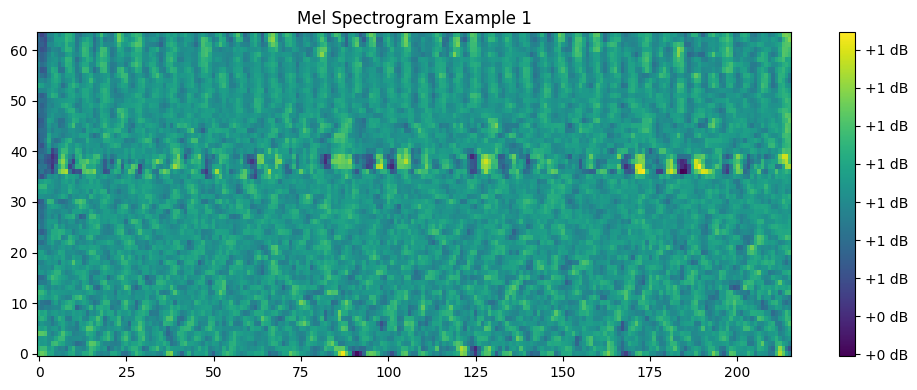

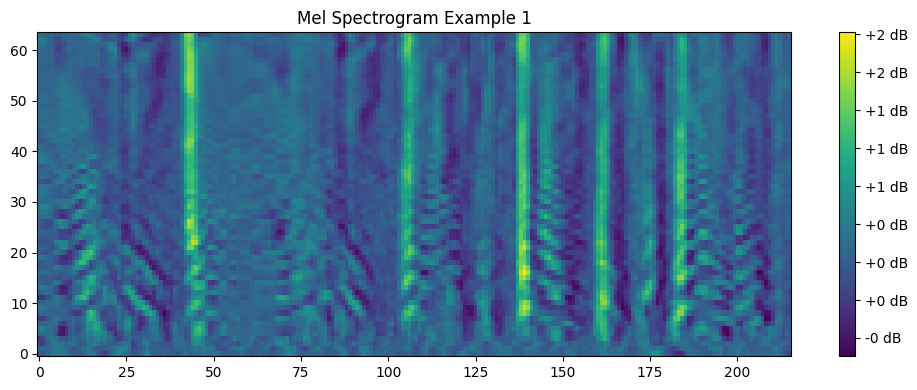

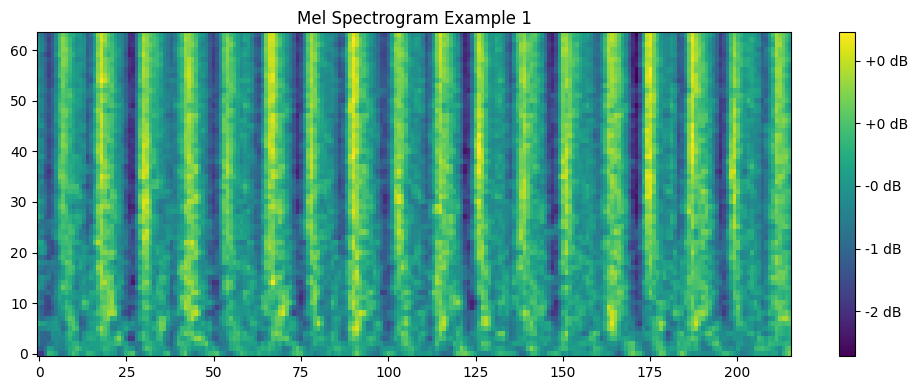

In [238]:
print("查看train_loader中的样本:")
for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):
    print(f"批次 {batch_idx}，样本数量: {batch_data.size(0)}")
    print("梅尔频谱图形状:", batch_data.shape)
    for idx in range(4):
        mel_spec = batch_data[idx,1,:,:]
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spec, origin='lower', aspect='auto', cmap='viridis')
        plt.title(f"Mel Spectrogram Example { 1}")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    if batch_idx == 0:  # 只查看第一个批次
        break




### 构建深度学习模型

In [239]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnvironmentalSoundClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EnvironmentalSoundClassifier, self).__init__()
        # 第一层卷积
        self.conv1 = nn.Conv2d(2, 80, kernel_size=(57, 6), stride=(1, 1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 3), stride=(1, 3))
        # 第二层卷积
        self.conv2 = nn.Conv2d(80, 80, kernel_size=(1, 3), stride=(1, 1),padding=(0,1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        # 计算池化后的特征图维度以调整全连接层
        self.fc1 = nn.Linear(80 * 5 * 23, 5000)  # 调整全连接层的输入大小
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(5000, 5000)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        # 输出层
        self.fc3 = nn.Linear(5000, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [240]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnvironmentalSoundClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EnvironmentalSoundClassifier, self).__init__()
        # 第一层卷积
        self.conv1 = nn.Conv2d(2, 16, kernel_size=(1, 3), stride=(1, 1),padding=(1,1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        # 第二层卷积
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 3), stride=(1, 1),padding=(0,1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        # 第三层卷积
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1),padding=(1,1))
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # 第四层卷积
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),padding=(1,1))
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # 第五层卷积
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1),padding=(1,1))
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # 第六层卷积
        self.conv6 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),padding=(1,1))
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # 计算池化后的特征图维度以调整全连接层
        self.fc1 = nn.Linear(256 * 4 * 3, 1024)  # 调整全连接层的输入大小
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        # 输出层
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.pool6(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

查看网络结构和测试

In [241]:
# 创建网络实例
net = EnvironmentalSoundClassifier(50)

# 打印网络结构以验证
print(net)

# 创建一个示例输入并进行前向传播以验证网络结构
example_input = torch.randn(32, 2, 64, 216) 
output = net(example_input)
print(output.shape,output)

EnvironmentalSoundClassifier(
  (conv1): Conv2d(2, 16, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (pool5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv6): Co

### 模型训练

保存模型检查点

In [242]:
def save_checkpoint(model, optimizer, epoch, loss, filename='RawWaveformCNNResidual.pth'):
    """
    保存模型检查点。

    参数：
    - model: 要保存的模型
    - optimizer: 模型对应的优化器
    - epoch: 当前的epoch
    - loss: 当前的损失
    - filename: 检查点保存的文件名
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)

加载模型检查点

In [243]:
def load_checkpoint(model, optimizer, filename='RawWaveformCNNResidual.pth'):
    """
    加载模型检查点。

    参数：
    - model: 初始化的模型实例
    - optimizer: 初始化的优化器实例
    - filename: 检查点文件名

    返回：
    - epoch: 上次保存时的epoch
    - loss: 上次保存时的损失
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss


构建模型训练和验证函数

In [244]:

def train_model(model, train_loader, val_loader, epochs, learning_rate,filename = 'EnvironmentalSoundClassifier.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        # 训练阶段
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            save_checkpoint(model, optimizer, epoch, val_epoch_loss,filename=filename)

        print(f'Epoch {epoch + 1} Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} '
              f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
    return best_val_acc

超参数设置

In [245]:
num_classes = 50  # ESC-50数据集有50个类别
model = EnvironmentalSoundClassifier(num_classes)
epochs = 200
learning_rate = 0.001

训练

In [246]:
best_val_acc = train_model(model, train_loader, val_loader, epochs, learning_rate)
print("最好的结果为：ACC=",best_val_acc)

Epoch 1 Train Loss: 3.9141 Train Acc: 0.0244 Val Loss: 3.8535 Val Acc: 0.0250
Epoch 2 Train Loss: 3.6806 Train Acc: 0.0331 Val Loss: 3.5955 Val Acc: 0.0325
Epoch 3 Train Loss: 3.5358 Train Acc: 0.0413 Val Loss: 3.4889 Val Acc: 0.0450
Epoch 4 Train Loss: 3.3509 Train Acc: 0.0775 Val Loss: 3.2184 Val Acc: 0.0775
Epoch 5 Train Loss: 3.1143 Train Acc: 0.1144 Val Loss: 3.0553 Val Acc: 0.1300
Epoch 6 Train Loss: 2.9109 Train Acc: 0.1656 Val Loss: 2.8304 Val Acc: 0.2025
Epoch 7 Train Loss: 2.6721 Train Acc: 0.2281 Val Loss: 2.5858 Val Acc: 0.2400
Epoch 8 Train Loss: 2.5077 Train Acc: 0.2594 Val Loss: 2.4934 Val Acc: 0.2875
Epoch 9 Train Loss: 2.3245 Train Acc: 0.3013 Val Loss: 2.3798 Val Acc: 0.2800
Epoch 10 Train Loss: 2.1619 Train Acc: 0.3544 Val Loss: 2.2135 Val Acc: 0.3450
Epoch 11 Train Loss: 2.0287 Train Acc: 0.3894 Val Loss: 2.1288 Val Acc: 0.3875
Epoch 12 Train Loss: 1.8454 Train Acc: 0.4288 Val Loss: 2.0911 Val Acc: 0.3800
Epoch 13 Train Loss: 1.7300 Train Acc: 0.4625 Val Loss: 2.104